In [1]:
import sys
import os
import ee 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

#import cv2
import pickle
import datetime
import numpy as np
import numpy.ma as ma
import pandas as pd
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns

#sys.path.append('/home/maya/Dropbox/InternshipWUR/Scripting/git_workspace/S2DataProcessing/')
import matplotlib.pyplot as plt
from s2cloudless import *
from glob import glob

import rasterio
import geopandas as gpd
from shapely.geometry import mapping
#import earthpy as et
#import earthpy.spatial as es
#from osgeo import gdal, gdal_array, osr

plt.ion()
sns.set_style('white')
sns.set(font_scale=1.5)

#os.chdir(os.path.join(et.io.HOME, 'Documents/USNInternship/Sentinel_Imagery/'))

ee.Initialize()

INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:oauth2client.client:Refreshing access_token


In [2]:
def overlay_cloud_mask(image, mask=None, factor=1./255, figsize=(15, 15), fig=None):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    rgb = np.array(image)
    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255, 255, 0, 100], dtype=np.uint8)
        plt.imshow(cloud_image)
def plot_probability_map(rgb_image, prob_map, factor=1./255, figsize=(15, 30)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 2, 1)
    plt.imshow(rgb_image * factor)
    plot = plt.subplot(1, 2, 2)
    plot.imshow(prob_map, cmap=plt.cm.inferno)
def plot_cloud_mask(mask, figsize=(15, 15), fig=None):
    """
    Utility function for plotting a binary cloud mask.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    plt.imshow(mask, cmap=plt.cm.gray)
def plot_previews(data, dates, cols=4, figsize=(15, 15)):
    """
    Utility to plot small "true color" previews.
    """
    width = data[-1].shape[1]
    height = data[-1].shape[0]
    
    rows = data.shape[0] // cols + (1 if data.shape[0] % cols else 0)
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for index, ax in enumerate(axs.flatten()):
        if index < data.shape[0]:
            caption = '{}: {}'.format(index, dates[index].strftime('%Y-%m-%d'))
            ax.set_axis_off()
            ax.imshow(data[index] / 255., vmin=0.0, vmax=1.0)
            ax.text(0, -2, caption, fontsize=12, color='g')
        else:
            ax.set_axis_off()

In [21]:
AOI = ee.Geometry.Rectangle(8.212529728804157, 60.11440450337899, 8.025762150679157, 60.02086917002816)

import ee
ee.Initialize()
image = ee.Image(ee.ImageCollection("COPERNICUS/S2")\
        .filterBounds(AOI)\
        .filterDate('2017-10-01', '2017-10-07').first())

imarr = np.array(image)

In [104]:
area = ee.Geometry.Polygon([[[105.532,19.059],[105.606,19.058],[105.605,19.108],
                             [105.530,19.110],[105.532,19.059]]])
 
# define the image
img = ee.Image("COPERNICUS/S2/20160209T034234_20160209T090731_T48QWG")
 
# do any ee operation here
ndvi = ee.Image(img.normalizedDifference(['B8', 'B4']))
img_relbands = ee.Image(img.select(['B1', 'B2', 'B4', 'B5', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']))
timedate = img.get('GENERATION_TIME').getInfo()
 
# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(img.select(['B1','B2','B4','B5','B8','B8A','B9','B10','B11','B12']))
#latlon = ee.Image.pixelLonLat().addBands(ndvi) 

# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels=1e8,
  scale=20)

### script from https://mygeoblog.com/2017/10/06/from-gee-to-numpy-to-geotiff/ 

In [108]:
# get data into different arrays
#data = np.array((ee.Array(latlon.get("nd")).getInfo()))
B1 = np.array((ee.Array(latlon.get('B1')).getInfo()))
B2 = np.array((ee.Array(latlon.get('B2')).getInfo()))
B4 = np.array((ee.Array(latlon.get('B4')).getInfo()))
B5 = np.array((ee.Array(latlon.get('B5')).getInfo()))
B8 = np.array((ee.Array(latlon.get('B8')).getInfo()))
B8A = np.array((ee.Array(latlon.get('B8A')).getInfo()))
B9 = np.array((ee.Array(latlon.get('B9')).getInfo()))
B10 = np.array((ee.Array(latlon.get('B10')).getInfo()))
B11 = np.array((ee.Array(latlon.get('B11')).getInfo()))
B12 = np.array((ee.Array(latlon.get('B12')).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
 
# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)
 
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]

(116491,) (116491,) (116491,) (116491,)


In [161]:
data = np.array((B1,B2,B4,B5,B8,B8A,B9,B10,B11,B12))
#for i in range(0,10):
#    print( i )

In [164]:
# create an array with dimensions of image (3D array, as it is a multiband image we want)
# this has not worked properly - check script
arr2 = np.zeros([nrows, ncols,10], np.float32) #-9999

counter2 =0            

for y in range(0,len(arr2),1):
    for x in range(0,len(arr2[0]),1):
        for z in range(0,10): #put 10 here, as 10 bands are input (put 13 if all 13 are input etc)
            if lats[counter2] == uniqueLats[y] and lons[counter2] == uniqueLons[x] and counter2 < len(lats)-1:
                counter2+=1
                arr2[len(uniqueLats)-1-y,x] = data[z][counter2] # we start from lower left corner

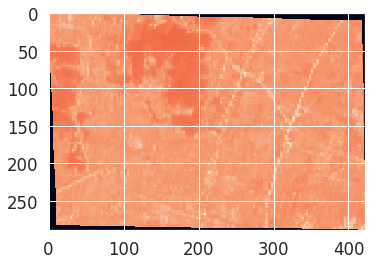

In [169]:
import matplotlib.pyplot as plt        
plt.imshow(arr2[:,:,1])
plt.show()

In [173]:
arr2[:,:,5]
len(arr2.shape)

3

In [165]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

In [166]:
cloud_probs = cloud_detector.get_cloud_probability_maps(arr2)

ValueError: Array of input images has to be a 4-dimensional array of shape[n_images, n_pixels_y, n_pixels_x, n_bands]

In [ ]:
cloud_masks = cloud_detector.get_cloud_masks(np.array(wcsbands))